In [8]:
# Standard Library Imports
import copy
import os
import sys
import traceback

# Third-Party Imports
import matplotlib.pyplot as plt
import requests
import ROOT
import tqdm
import uproot
import awkward as ak
import vector
vector.register_awkward()
from cernopendata_client import searcher

# Local Application Imports
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from parse_atlas import consts, parser, schemas

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
atlas_parser = parser.ATLAS_Parser()
atlas_parser.get_records_file_index([consts.ATLAS_ELECTROWEAK_BOSON], file_idx=[consts.ZMUMU])
# atlas_parser.get_records_file_index(consts.ATLAS_13TEV_RECIDS)

Successfuly retrieved all indexes.
Total amount of files found -  38


In [36]:
atlas_parser.parse_all_files(schemas.E_POSI_MUON_SCHEMA, limit = 10)

INFO:root:Processing file - root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37865997._000001.pool.root.1
INFO:root:Finished, file number 1
INFO:root:Processing file - root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37865997._000002.pool.root.1
INFO:root:Finished, file number 2
INFO:root:Processing file - root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37865997._000003.pool.root.1
INFO:root:Finished, file number 3
INFO:root:Processing file - root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37865997._000004.pool.root.1
INFO:root:Finished, file number 4
INFO:root:Processing file - root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37865997._000005.pool.root.1
INFO:root:Finished, file number 5
INFO:root:Processing file - root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37865997._000006.pool.root.1
INFO:root:Finished, file number 

In [38]:
GeV = 1000.

def selected_electrons(el):
    return el[(el.pt > 10 * GeV) & (abs(el.eta) < 2.47)]

def selected_muons(mu):
    return mu[(mu.pt > 10 * GeV) & (abs(mu.eta) < 2.47)]

def selected_jets(j):
    return j[(j.pt > 10 * GeV) & (abs(j.eta) < 2.47)]

def no_overlap(obj1, obj2, deltaR=0.4):
    obj1, obj2 = ak.unzip(ak.cartesian([obj1, obj2], nested=True))
    return ak.all(obj1.deltaR(obj2) > deltaR, axis=-1)

def mjjj(jets):
    candidates = ak.combinations(jets, 3)
    j1, j2, j3 = ak.unzip(candidates)
    has_b = (j1.is_bjet + j2.is_bjet + j3.is_bjet) > 0
    candidates["p4"] = j1 + j2 + j3
    candidates = candidates[has_b]
    candidates = candidates[ak.argmax(candidates.p4.pt, axis=1, keepdims=True)]
    return candidates.p4.mass

def processed(events):
    events = copy.copy(events) # shallow copy
    events["Jets", "btag_prob"] = events.BTagging_AntiKt4EMPFlow.DL1dv01_pb
    events["Electrons"] = selected_electrons(events.Electrons)
    events["Muons"] = selected_muons(events.Muons)
    events["Jets"] = selected_jets(events.Jets)
    events["Jets"] = events.Jets[no_overlap(events.Jets, events.Electrons)]
    events["Jets", "is_bjet"] = events.Jets.btag_prob > 0.85
    events = events[
        (ak.num(events.Jets) >= 4) # at least 4 jets
        & ((ak.num(events.Electrons) + ak.num(events.Muons)) == 1) # exactly one lepton
        & (ak.num(events.Jets[events.Jets.is_bjet]) >= 2) # at least two btagged jets with prob > 0.85
    ]
    return ak.to_packed(events)

events = processed(atlas_parser.events)
plt.hist(ak.flatten(mjjj(events.Jets) / GeV, axis=None), bins=100)
plt.xlabel("Reconstructed Top Quark Mass (GeV)")
plt.ylabel("Number of Events")
plt.title("Distribution of Reconstructed Top Quark Mass")
plt.axvline(172.76, color='r', linestyle='dashed', linewidth=2, label='Expected Top Quark Mass')
plt.legend()
plt.show()

print('Total events:', f"{len(atlas_parser.events):,}")
print('Events after filtering:', f"{len(events):,}")

AttributeError: no field named 'BTagging_AntiKt4EMPFlow'

[{Electrons: [{rho: 1.59e+04, ...}, ...], Muons: [...]}, {...}, ..., {...}]


/tmp/ipykernel_7693/353947300.py:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


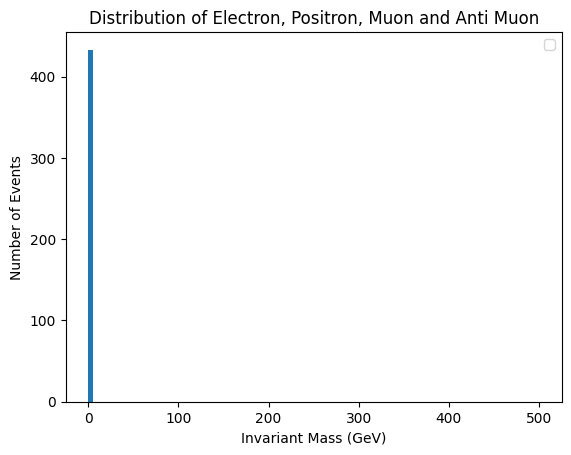

Total events: 480,000
Events after filtering: 433


In [39]:
def selected_muons(mu):
    return mu[(mu.pt > 10 * GeV) & (abs(mu.eta) < 2.5)]

def selected_electrons(el):
    return el[(el.pt > 10 * GeV) & (abs(el.eta) < 2.47)]

def electron_posi_muon_antimuon(events):
    events = copy.copy(events) # shallow copy
    events["Electrons"] = selected_electrons(events.Electrons)
    events["Muons"] = selected_muons(events.Muons)
    events["Electrons", "is_neg"] = events.Electrons.charge < 0
    events["Muons", "is_neg"] = events.Muons.charge < 0
    events = events[
        (ak.num(events.Electrons) == 2) # Exactly two electrons
        | (ak.num(events.Muons) == 2)  # Exactly two muons
        & (ak.num(events.Electrons[events.Electrons.is_neg]) == 1) # Ensure positron
        | (ak.num(events.Muons[events.Muons.is_neg]) == 1)  # One negative muon
    ]
    return ak.to_packed(events)

def combine_four_momenta(electrons, muons):
    electron_candidates = ak.combinations(electrons, 2)
    e1, e2 = ak.unzip(electron_candidates)
    electron_p4 = e1 + e2
    # return electron_p4.to_ptphietamass().mass

    muon_candidates = ak.combinations(muons, 2)
    m1, m2 = ak.unzip(muon_candidates)
    muon_p4 = m1 + m2

    combined_p4 = electron_p4 + muon_p4

    return combined_p4.to_ptphietamass().mass

# Process the events
events = electron_posi_muon_antimuon(atlas_parser.events)
print(events)
# Calculate the invariant mass for each event
inv_mass = combine_four_momenta(events.Electrons, events.Muons)

# Plot the invariant mass distribution
plt.hist(inv_mass / GeV, bins=100, range=(0, 500))
plt.xlabel("Invariant Mass (GeV)")
plt.ylabel("Number of Events")
plt.title("Distribution of Electron, Positron, Muon and Anti Muon")
plt.legend()
plt.show()

print('Total events:', f"{len(atlas_parser.events):,}")
print('Events after filtering:', len(events))